In [76]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.similarity import graph_edit_distance
warnings.filterwarnings("ignore")


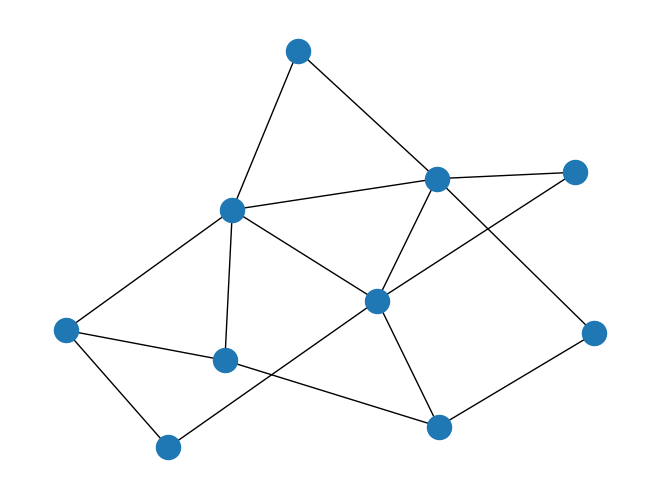

In [5]:
graph = nx.barabasi_albert_graph(10,2)
nx.draw(graph, with_labels=False)
plt.show()

In [4]:
graph.number_of_nodes()

10

In [35]:
density_sum = 0
for i in range(100):
    n = random.randint(30,50)       
    p = round(random.uniform(5, 40))/100
    graph = nx.erdos_renyi_graph(n,p)
    edge_density = nx.density(graph)
    density_sum = density_sum + edge_density
print(density_sum/100)

0.2215781402162677


In [67]:
density_sum = 0
for i in range(100):
    n = random.randint(30,50)       
    m = random.randint(2,8)  
    graph = nx.barabasi_albert_graph(n,m)
    edge_density = nx.density(graph)
    density_sum = density_sum + edge_density
print(density_sum/100)

0.22757340464243245


In [69]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [70]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity

In [71]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

In [72]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 5  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.3))
    return km.to_nx(graph)

In [88]:
def calc_average_for_hop(hop,ref_graph,n,m,delta_n,delta_m):
    sum_original = 0
    sum_TDA = 0
    counter = 0
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = nx.barabasi_albert_graph(i*delta_n + n,j*delta_m + m)
                
                TDA_graph = TDA_transformation(extract_graph_features(ref_graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                
                score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                score_original = calculate_similarity(ref_graph, neighbour)
                
                sum_TDA += score_TDA
                sum_original += score_original
                counter += 1
    return {"hop:" : hop,"TDA": sum_TDA/counter,"original": sum_original/counter}
                

In [89]:
G = nx.barabasi_albert_graph(30,5)

result = calc_average_for_hop(hop = 1,ref_graph = G,n = 30,m = 5,delta_n = 2,delta_m = 1)
result

{'hop:': 1, 'TDA': 10.17865240489353, 'original': 67.3992007490488}

In [98]:
def conduct_test_for_on_graph(graph,n,m,delta_n,delta_m,n_hop):
    result = [dict() for x in range(n_hop)]
    for i in range(n_hop):
        result[i] = calc_average_for_hop(hop =i+1,ref_graph = graph,n = n,m = m,delta_n = delta_n,delta_m = delta_m)
    return {"n" : n,"m" : m,"Result" : result}

In [101]:
def conduct_test_on_sample(sample_numbers,n_hop):
    column = []
    row_list = []
    column.append('n')
    column.append('m')
    
    for i in range(n_hop):
        original_text = "Original_"
        TDA_text = "TDA_"
        original_text = original_text + str(i+1)
        TDA_text = TDA_text + str(i+1)
        column.append(original_text)
        column.append(TDA_text)
        
    for i in range(sample_numbers):
        row =[]
        n = random.randint(30,50)       
        m = random.randint(5,8) 
        row.append(n)
        row.append(m)
        reference_graph = nx.barabasi_albert_graph(n,m)
        result = conduct_test_for_on_graph(reference_graph,n,m,2,1,n_hop)['Result']

        for j in range(n_hop):
            row.append(result[j]['original'])
            row.append(result[j]['TDA'])
        row_list.append(row)
       
    df = pd.DataFrame(row_list,columns= column)
    return df
        

In [104]:
df_result = conduct_test_on_sample(30,4)

In [105]:
df_result

,n,m,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,42,5,106.200829,10.118184,354.701035,13.621754,708.359545,13.367768,1144.161180,12.913484
1,37,6,103.958889,8.955605,267.004578,12.102249,503.705654,12.307476,827.505640,11.899364
2,30,7,58.354074,7.492639,164.104942,13.489145,293.646043,14.041965,483.935490,14.792574
3,33,6,77.039501,11.519166,197.852714,9.574831,402.132203,11.271254,640.680261,14.559862
4,43,8,106.050669,13.691267,289.990031,8.428624,584.098371,12.126472,913.911972,10.454314
5,45,8,138.675310,11.335000,340.842608,11.065726,651.285669,12.501223,1029.964961,13.315745
6,47,6,141.080570,14.550967,362.833495,14.950880,753.683913,16.240317,1205.034077,20.680806
7,31,5,79.328267,10.811559,220.859831,10.948217,398.882855,20.641740,654.672328,13.084119
8,30,6,70.423521,10.725821,160.971853,13.751831,333.448921,16.155983,529.489297,12.994654
9,33,8,56.549721,11.317244,152.110350,11.745045,281.093836,11.962501,457.763289,11.950460


In [111]:
df_result.to_csv("30_sample_graphs-BA.csv")

In [106]:
original_average =[]
TDA_avaerage = []
for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_result[original_text].tolist()
    tda_list = df_result[TDA_text].tolist()
    original_sum = 0
    tda_sum = 0
    for j in range(len(original_list)):
        original_sum = original_sum + original_list[j]
        tda_sum = tda_sum + tda_list[j]
    original_average.append(round(original_sum/len(original_list),2))
    TDA_avaerage.append(round(tda_sum/len(tda_list),2))
    

In [107]:
original_average

[94.36, 256.82, 500.11, 812.11]

In [108]:
TDA_avaerage

[10.62, 11.37, 12.54, 12.71]

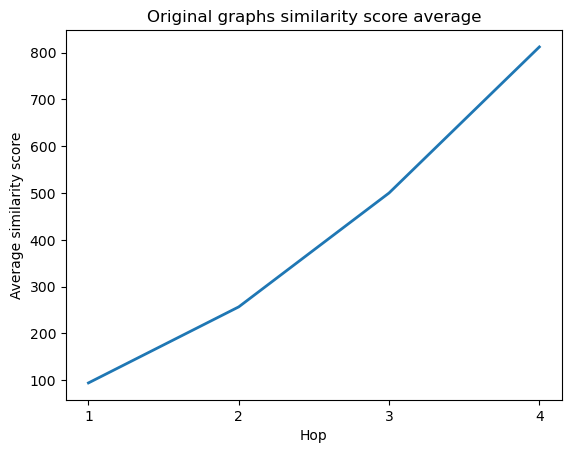

In [109]:
hop = ['1','2','3','4']
plt.plot(hop, original_average,linewidth=2, markersize=12)
plt.title('Original graphs similarity score average')
plt.xlabel('Hop')
plt.ylabel('Average similarity score')
plt.savefig("original-BA.jpg")
plt.show()

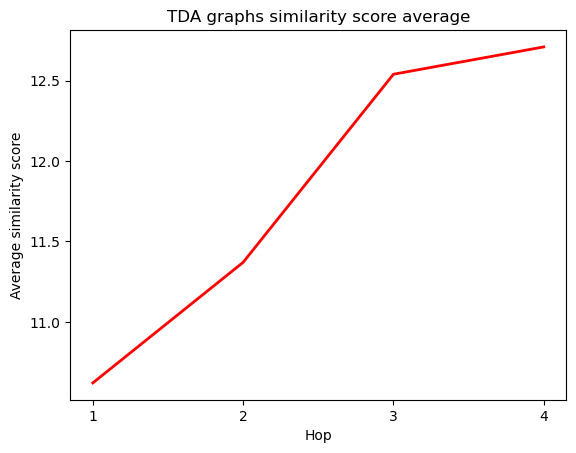

In [110]:
plt.plot(hop, TDA_avaerage,linewidth=2, markersize=12,color='red')
plt.title('TDA graphs similarity score average')
plt.xlabel('Hop')
plt.ylabel('Average similarity score')
plt.savefig("TDA-BA.jpg")
plt.show()